In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.tri as tri
import pickle
import sys
import torch

sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from summaryutils import summary, setStatSim

In [2]:
in_dir = '/home/qh8373/SBI_TAYLOR/data/03_ensemble_out/_ensemble_0819_01_mod2/'
nm = 'df_l_scaled'
df_l = pd.read_csv(in_dir+nm+'.csv')

In [3]:
cols = df_l.columns

In [13]:
col_list_K = ['Flow_K-0.001-M-2.5e-06-_1995_9110000',
            'Flow_K-0.01-M-2.5e-06-_1995_9110000',
             'Flow_K-0.025-M-2.5e-06-_1995_9110000',
             'Flow_K-0.05-M-2.5e-06-_1995_9110000',
             'Flow_K-0.075-M-2.5e-06-_1995_9110000',
            'Flow_K-0.1-M-2.5e-06-_1995_9110000',
             'Flow_K-0.25-M-2.5e-06-_1995_9110000',
             'Flow_K-0.5-M-2.5e-06-_1995_9110000',
             'Flow_K-0.75-M-2.5e-06-_1995_9110000',
            'Flow_K-1.0-M-2.5e-06-_1995_9110000',
             'Flow_K-2.5-M-2.5e-06-_1995_9110000',
             'Flow_K-5.0-M-2.5e-06-_1995_9110000',
             'Flow_K-7.5-M-2.5e-06-_1995_9110000',
            'Flow_K-10.0-M-2.5e-06-_1995_9110000']
            
            
col_list_M = ['Flow_K-1.0-M-1e-08-_1995_9110000',
              'Flow_K-1.0-M-1e-07-_1995_9110000',
              'Flow_K-1.0-M-2.5e-07-_1995_9110000',
              'Flow_K-1.0-M-5e-07-_1995_9110000',
              'Flow_K-1.0-M-7.5e-07-_1995_9110000',
              'Flow_K-1.0-M-1e-06-_1995_9110000',
              'Flow_K-1.0-M-2.5e-06-_1995_9110000',
              'Flow_K-1.0-M-5e-06-_1995_9110000',
              'Flow_K-1.0-M-7.5e-06-_1995_9110000',
              'Flow_K-1.0-M-1e-05-_1995_9110000',
              'Flow_K-1.0-M-2.5e-05-_1995_9110000',
              'Flow_K-1.0-M-5e-05-_1995_9110000',
              'Flow_K-1.0-M-0.0001-_1995_9110000']
#               'Flow_K-1.0-M-0.001-_1995_9110000']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


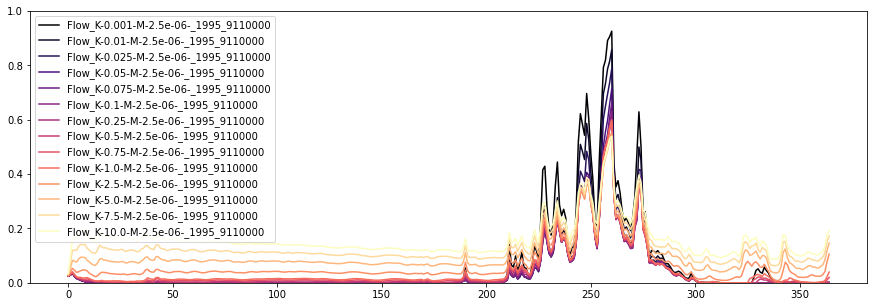

In [14]:
out_nm ='out_dir_full_K'
df_l_plot = df_l[col_list_K]
df_l_plot.plot(figsize=(15,5),cmap='magma')

plt.ylim(0.0, 1.0)
plt.savefig(in_dir+out_nm+'.png')
plt.savefig(in_dir+out_nm+'.eps',format='eps')
plt.show()


In [4]:
def gen_2D_surface(z_name, z_arr, param_arr, save_dir, sub, trueflow=False, true_flow_idx=None, ngrid=50, levels=10, norm_bool=False, cmap="RdBu_r", save_bool=True):
    '''
    For generating a 2D surface
    Takes:
        z_name : string containing the name of the variable visualized
        z_arr : array (1D) containing the metric to plot the surface of
        param_arr : a parameter array 2xn, the x and y variables on the plot
        how coarse / fine to interpolate the grid
        save_dir : where to save
        ngrad : something to do with the spacing used to interpolate
        levels : something to do with how close or far apart to do the interpolation
    '''
    ngridx = ngrid
    ngridy = ngrid
    x = param_arr[:,0]
    y = param_arr[:,1]

    # HELP
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html
    fig, ax = plt.subplots(figsize=(10, 10))

    # -----------------------
    # Interpolation on a grid
    # -----------------------
    # A contour plot of irregularly spaced data coordinates
    # via interpolation on a grid.

    # Create grid values first.
    xi = np.linspace(-0.1,1.1, ngridx) # potentailly edit this range
    yi = np.linspace(-0.1,1.1, ngridy) # potentially edit this range

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z_arr)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    #from scipy.interpolate import griddata
    #zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

    if norm_bool:
        ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
        cntr1 = ax.contourf(xi, yi, zi, levels=levels, cmap=cmap, extend='both',
                           norm=colors.LogNorm(vmin=levels.min(), vmax=levels.max()))
    else:
        ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
        cntr1 = ax.contourf(xi, yi, zi, levels=levels, cmap=cmap, extend='both')

    fig.colorbar(cntr1, ax=ax)
    ax.plot(x, y, 'ko', ms=3)
    # plot 'true flows' if it is thrown, which just means symbologize the last few to be 'true flows'
    if trueflow:
        ax.plot(x[true_flow_idx:], y[true_flow_idx:],'*',ms=5,color='gold')
    
    ax.set(xlim=(0,1), ylim=(0, 1))
    ax.set_title(f'{z_name} grid and contour (%d points, %d grid points)' %
                  (len(z_arr), ngridx * ngridy))
    ax.set_aspect('equal')
    if save_bool:
        plt.savefig(f'{save_dir}{sub}/{z_name}_surf.png')
        plt.savefig(f'{save_dir}{sub}/{z_name}_surf.eps',format='eps')
    plt.show()
    plt.close()
    
    return None

In [24]:
stat_typ = np.array([1, 3, 4, 5, 7, 9, 10, 11])
AOC_ens_scale_l = pickle.load(open(in_dir+'AOC_ens_scale_l.pkl', 'rb'))

columns = df_l.columns[9:-1]
stat_arr = torch.empty(len(columns), len(stat_typ))

for idx in range(len(columns)):
    col = columns[idx]
    y_o = torch.tensor(df_l[col].to_numpy())
    stat_sim = setStatSim(y_o, stat_typ)
    stat_arr[idx,:] = torch.tensor(stat_sim)
    
    del y_o, stat_sim


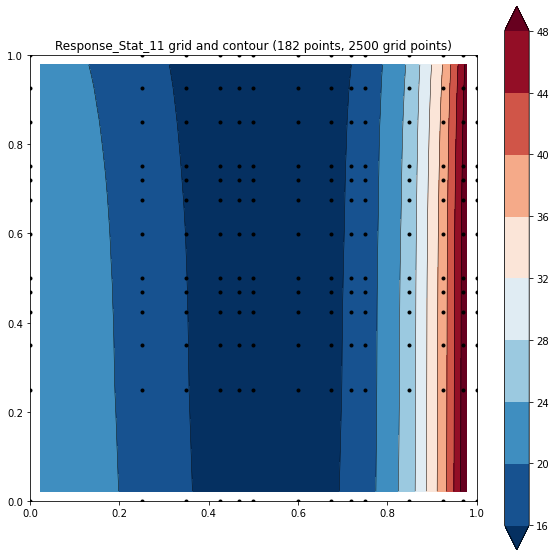

In [32]:
sub = 'summary'
save_dir = in_dir
z_idx = 7
stat = stat_typ[z_idx]
z_arr = stat_arr[:,z_idx]
lag = 14
levels=10
z_name = f'Response_Stat_{stat}'
levels_list = {stat_typ[0] : np.linspace(0.04,0.14,levels), # np.linspace(0.04,0.14,levels)
               stat_typ[1] : levels,
               stat_typ[2] : levels,
               stat_typ[3] : levels,
               stat_typ[4] : levels,
               stat_typ[5] : np.linspace(0.42,0.96,levels), # np.linspace(0.42,0.96,levels)
               stat_typ[6] : np.linspace(244+lag,252+lag,levels), # np.linspace(259,266,levels)
               stat_typ[7] : levels
              }

save_bool = True


gen_2D_surface(z_name=z_name, z_arr=z_arr, param_arr=AOC_ens_scale_l,
               save_dir=save_dir, sub=sub, trueflow=False, true_flow_idx=None, ngrid=50, levels=levels_list[stat], norm_bool=False, cmap="RdBu_r", save_bool=save_bool)